In [23]:

import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
#from composition_stats import clr
import anndata as ad
import scirpy as ir


In [24]:
!pip install git+https://github.com/gtca/muon.git

  Cloning https://github.com/gtca/muon.git to c:\users\okatk\appdata\local\temp\pip-req-build-yry5ptkf
  Resolved https://github.com/gtca/muon.git to commit 6192f7698d8f3eca39412cd63699ef0b6a927d64
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/gtca/muon.git 'C:\Users\okatk\AppData\Local\Temp\pip-req-build-yry5ptkf'


In [25]:
import muon as mu

In [26]:
help(ir)

Help on package scirpy:

NAME
    scirpy - Python library for single-cell adaptive immune receptor repertoire (AIRR) analysis

PACKAGE CONTENTS
    _compat
    _metadata
    datasets (package)
    get (package)
    io (package)
    ir_dist (package)
    pl (package)
    pp (package)
    tests (package)
    tl (package)
    util (package)

VERSION
    0.13.0rc1

FILE
    c:\users\okatk\appdata\local\programs\python\python311\lib\site-packages\scirpy\__init__.py




In [ ]:
!dir

In [28]:
# load in everything, perform batch correction with harmony and the normal qc from scirpy

file_list = [
     ir.io.read_10x_vdj(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\filtered_contig_annotations_lib_1.csv"), 
     ir.io.read_10x_vdj(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\filtered_contig_annotations_lib_2.csv"), 
     ir.io.read_10x_vdj(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\filtered_contig_annotations_lib_3.csv")
]
# 14206, 15031, 14752

#labels = 14206*["lib1"] +  15031* ["lib2"]+ 14752*["lib3"]
new_l = []
for index in range(len(file_list)):
    adata = file_list[index]
    adata.obs["batch"] = "lib_" + str(index)
    new_l.append(adata)
    


In [29]:
tcr_concat = ad.concat(new_l, merge="same")
# add batch labels
tcr_concat.obs_names_make_unique()
# now TCR qc
ir.pp.index_chains(tcr_concat) # only needs airr
ir.tl.chain_qc(tcr_concat) # only needs airr

print(tcr_concat.obs.receptor_subtype)
#raise Error
# further tcr qc
mu.pp.filter_obs(tcr_concat, "chain_pairing", lambda x: x != "multichain")
mu.pp.filter_obs(tcr_concat, "chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))
# it would appear that batch correction is ill-posed here.
# basic dim reduction for each modality
# sc.pp.pca(tcr_concat)
# # batch correction
# sce.pp.harmony_integrate(tcr_concat, 'batch') 
# then save it in same manner as other modalities
tcr_concat.write_h5ad(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\correct_tcr.h5ad")

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/43989 [00:00<?, ?it/s]

cell_id
AAACCTGAGACTAAGT-1      TRA+TRB
AAACCTGAGAGGGATA-1      TRA+TRB
AAACCTGAGCAATCTC-1      TRA+TRB
AAACCTGAGCCCAGCT-1      TRA+TRB
AAACCTGAGCTCCTCT-1      TRA+TRB
                         ...   
TTTGTCAGTGAAAGAG-1      TRA+TRB
TTTGTCAGTGAAGGCT-1      TRA+TRB
TTTGTCATCACGATGT-1      TRA+TRB
TTTGTCATCCACTGGG-1      TRA+TRB
TTTGTCATCTTGGGTA-1-1    TRA+TRB
Name: receptor_subtype, Length: 43989, dtype: object


In [30]:
print(tcr_concat.obs.receptor_subtype.unique())

['TRA+TRB']
Categories (1, object): ['TRA+TRB']


In [31]:
help(ir)


Help on package scirpy:

NAME
    scirpy - Python library for single-cell adaptive immune receptor repertoire (AIRR) analysis

PACKAGE CONTENTS
    _compat
    _metadata
    datasets (package)
    get (package)
    io (package)
    ir_dist (package)
    pl (package)
    pp (package)
    tests (package)
    tl (package)
    util (package)

VERSION
    0.13.0rc1

FILE
    c:\users\okatk\appdata\local\programs\python\python311\lib\site-packages\scirpy\__init__.py




In [32]:
# load in files 
file_list = [
    sc.read_h5ad(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\correct_rna.h5ad"),
    sc.read_h5ad(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\correct_tcr.h5ad"),
    sc.read_h5ad(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\correct_protein.h5ad")
]
for adata in file_list:
    try:
        adata.uns['log1p']["base"] = None 
    except:
        pass
# fill out the mudata object
mdata = mu.MuData({"gex": file_list[0],  
                   "airr": file_list[1],
                   "prot": file_list[2]})

mdata["gex"], mdata["airr"], mdata["prot"]

(AnnData object with n_obs × n_vars = 47024 × 28608
     obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Thaw', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
     var: 'gene_ids', 'featu

In [33]:
mdata["airr"].obs.receptor_subtype

cell_id
AAACCTGAGACTAAGT-1      TRA+TRB
AAACCTGAGCAATCTC-1      TRA+TRB
AAACCTGAGCCCAGCT-1      TRA+TRB
AAACCTGAGCTCCTCT-1      TRA+TRB
AAACCTGAGGACGAAA-1      TRA+TRB
                         ...   
TTTGTCAGTGAAAGAG-1      TRA+TRB
TTTGTCAGTGAAGGCT-1      TRA+TRB
TTTGTCATCACGATGT-1      TRA+TRB
TTTGTCATCCACTGGG-1      TRA+TRB
TTTGTCATCTTGGGTA-1-1    TRA+TRB
Name: receptor_subtype, Length: 40077, dtype: category
Categories (1, object): ['TRA+TRB']

In [34]:
airr_cell_ids = set(mdata["airr"].obs.index)
gex_cell_ids = set(mdata["gex"].obs.index)
prot_cell_ids = set(mdata["prot"].obs.index)

In [35]:
len(airr_cell_ids)

40077

In [36]:
len(gex_cell_ids)

47024

In [37]:
prot_cell_ids

{'CTCGAAAAGGATTCGG-1',
 'TCTCATATCCCTTGCA-1',
 'GTGCATATCTGTCTAT-1',
 'CGCCAAGTCACGCATA-1',
 'CTTAACTGTTAGAACA-1',
 'CTAGAGTGTATATCCG-1',
 'AAAGCAAAGATAGGAG-1',
 'ACTTTCAGTTGAACTC-1',
 'GGGAATGCATTCACTT-1',
 'ATAAGAGGTTGAACTC-1',
 'TTAGTTCGTCAGAGGT-1',
 'GAATGAACAGATGGGT-1',
 'GTAGGCCGTCTCATCC-1',
 'TCTCATACACGCTTTC-1',
 'ATCTGCCAGGCATGGT-1',
 'GGCGACTCACCGGAAA-1',
 'TCTCTAAGTGAGGGAG-1',
 'TGAGGGAAGACCCACC-1',
 'TTCTACAAGGGATCTG-1',
 'CTGCGGATCACTATTC-1',
 'ACTTTCAGTAGATTAG-1',
 'TAGTTGGCAGACGTAG-1',
 'CTGGTCTGTAAAGTCA-1',
 'TGGTTAGCAAGCGATG-1',
 'ATCATGGTCCTTTCGG-1',
 'TTAGGCATCTTGTATC-1',
 'AAGGCAGCACAGACAG-1',
 'CGTCCATCAGTTAACC-1',
 'GGGATGATCCTAGAAC-1',
 'TGCTACCAGACGCACA-1',
 'TTCTACAAGGGTTCCC-1',
 'CAACTAGTCCGCGGTA-1',
 'ACGAGCCCAAACGCGA-1',
 'ACGGGTCCACGAGAGT-1',
 'AAACGGGTCTTGTACT-1',
 'GAATAAGTCGGATGTT-1',
 'TGCCAAAGTTAGATGA-1',
 'GCGCGATTCACGATGT-1',
 'AGATTGCCAGGAATGC-1',
 'CCACCTAGTATTAGCC-1',
 'ATGGGAGGTCTTCAAG-1',
 'GACAGAGAGACTGTAA-1',
 'TGGCCAGAGTACGTTC-1',
 'TGGGCGTCA

In [38]:
len(airr_cell_ids), len(gex_cell_ids), len(prot_cell_ids)

(40077, 47024, 47024)

In [39]:
# check if there are cell barcodes that exist in airr and not in gex
#len(airr_cell_ids - gex_cell_ids), len(prot_cell_ids - gex_cell_ids), len(prot_cell_ids - airr_cell_ids), len(airr_cell_ids - prot_cell_ids)
# check if there are cell barcodes that exist in prot and not in gex
len(gex_cell_ids - airr_cell_ids)
# check if there are cell barcodes that exist in prot and not in airr

21596

  0%|          | 0/13524 [00:01<?, ?it/s]

Index(['gex:TotalSeq-C0251 anti-human Hashtag 1 Antibody',
       'gex:TotalSeq-C0252 anti-human Hashtag 2 Antibody',
       'gex:TotalSeq-C0253 anti-human Hashtag 3 Antibody',
       'gex:TotalSeq-C0254 anti-human Hashtag 4 Antibody',
       'gex:TotalSeq-C0255 anti-human Hashtag 5 Antibody',
       'gex:TotalSeq-C0256 anti-human Hashtag 6 Antibody',
       'gex:TotalSeq-C0257 anti-human Hashtag 7 Antibody',
       'gex:TotalSeq-C0258 anti-human Hashtag 8 Antibody',
       'gex:TotalSeq-C0259 anti-human Hashtag 9 Antibody',
       'gex:TotalSeq-C0260 anti-human Hashtag 10 Antibody',
       'gex:TotalSeq-C0262 anti-human Hashtag 12 Antibody',
       'gex:TotalSeq-C0263 anti-human Hashtag 13 Antibody',
       'gex:most_likely_hypothesis', 'gex:cluster_feature',
       'gex:negative_hypothesis_probability',
       'gex:singlet_hypothesis_probability',
       'gex:doublet_hypothesis_probability', 'gex:Classification', 'gex:Thaw',
       'gex:batch', 'gex:n_genes_by_counts', 'gex:total_cou

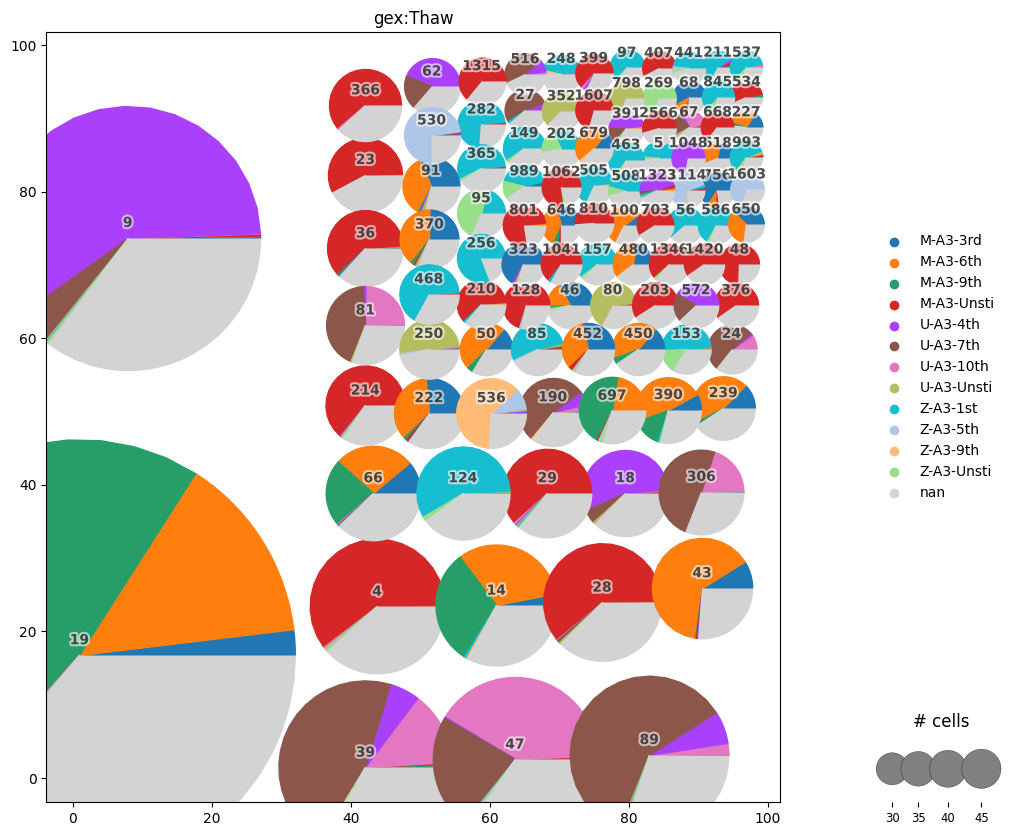

In [42]:
# define clonotypes
# using default parameters, `ir_dist` will compute nucleotide sequence identity

ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=30) #50, 100 is good
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Thaw') #, base_size=20, label_fontsize=9, panel_size=(7, 7)

print(mdata.obs.columns)


C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModification

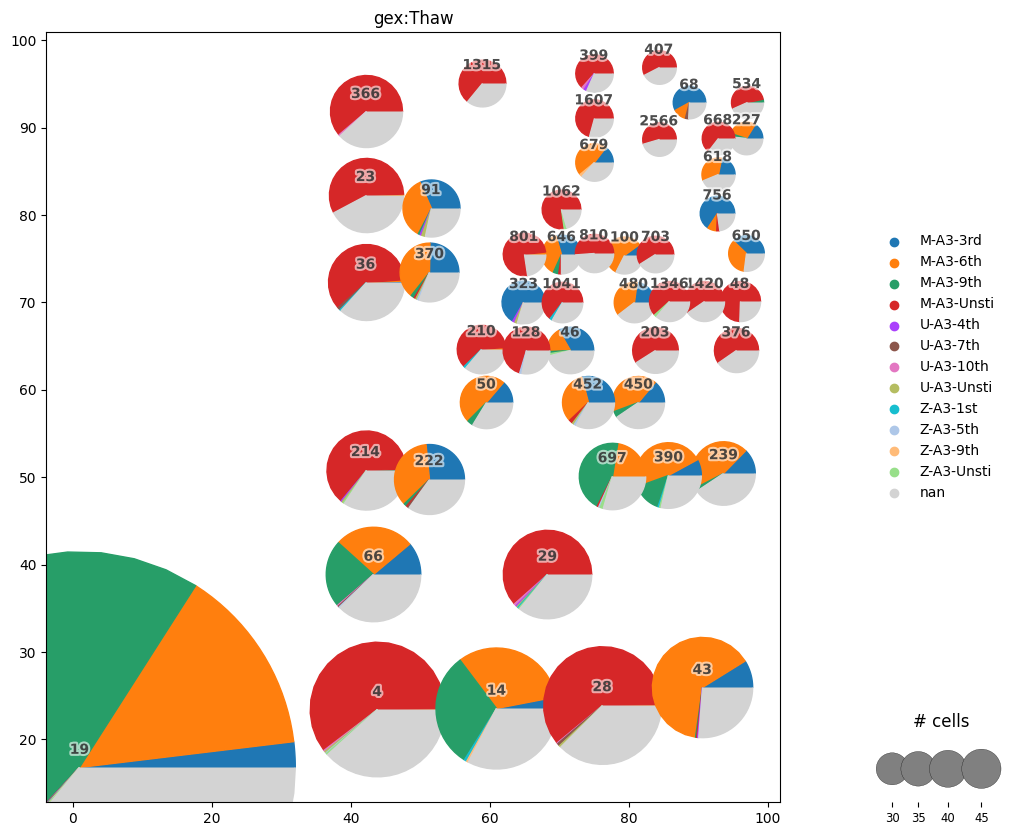

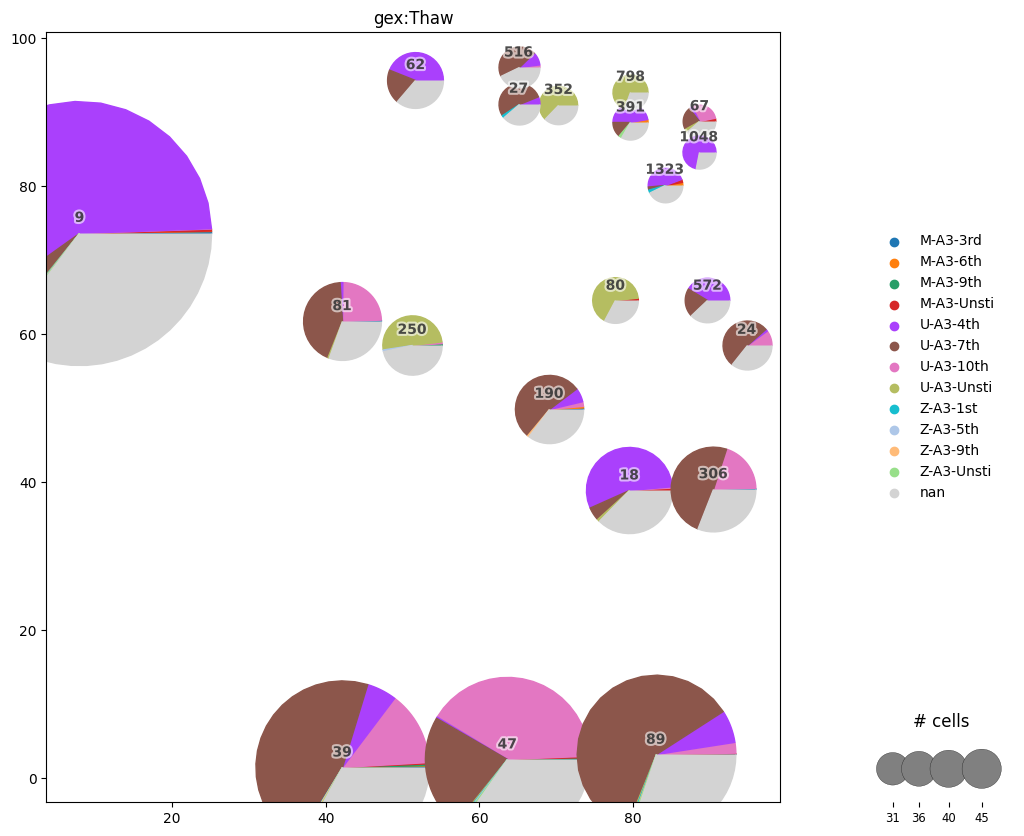

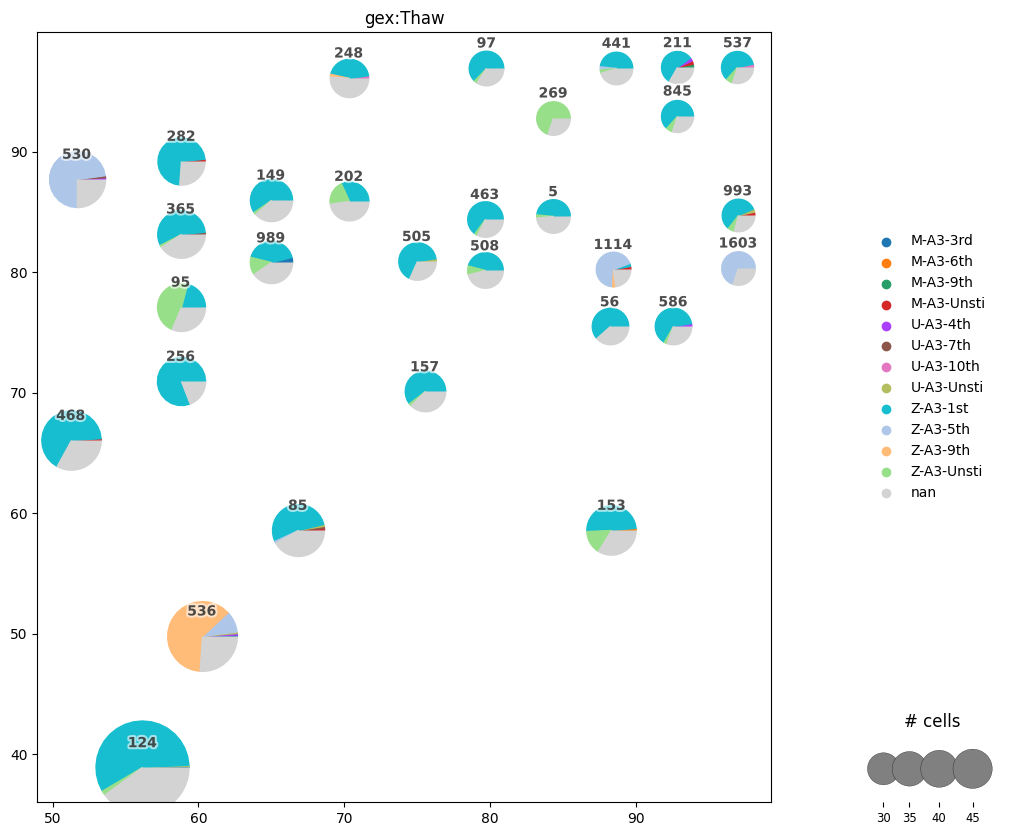

In [49]:
# Calculate the predominant donor for each clonotype
mdata.obs['donor'] = mdata["gex"].obs['Thaw'].apply(lambda x: x[0])

def get_predominant_donor(x):
    try:
        return x.value_counts().index[0]
    except IndexError:
        return None

predominant_donor = mdata.obs.groupby('airr:clone_id')['donor'].agg(get_predominant_donor)

# Map the predominant donor to each cell
mdata.obs['predominant_donor'] = mdata.obs['airr:clone_id'].map(predominant_donor)

# Get the unique donors
donors = mdata.obs['predominant_donor'].unique()

# Generate separate plots for each donor
for donor in donors:
    if donor is not None:  # Skip None
        subset = mdata[mdata.obs['predominant_donor'] == donor]
        if subset.obs.shape[0] > 0:  # Check that the subset has cells
            ir.pl.clonotype_network(
                subset, 
                color='gex:Thaw'  # Use the correct color attribute if you want to color the network differently
            )
            


In [46]:
print(mdata.obs.columns)

Index(['gex:TotalSeq-C0251 anti-human Hashtag 1 Antibody',
       'gex:TotalSeq-C0252 anti-human Hashtag 2 Antibody',
       'gex:TotalSeq-C0253 anti-human Hashtag 3 Antibody',
       'gex:TotalSeq-C0254 anti-human Hashtag 4 Antibody',
       'gex:TotalSeq-C0255 anti-human Hashtag 5 Antibody',
       'gex:TotalSeq-C0256 anti-human Hashtag 6 Antibody',
       'gex:TotalSeq-C0257 anti-human Hashtag 7 Antibody',
       'gex:TotalSeq-C0258 anti-human Hashtag 8 Antibody',
       'gex:TotalSeq-C0259 anti-human Hashtag 9 Antibody',
       'gex:TotalSeq-C0260 anti-human Hashtag 10 Antibody',
       'gex:TotalSeq-C0262 anti-human Hashtag 12 Antibody',
       'gex:TotalSeq-C0263 anti-human Hashtag 13 Antibody',
       'gex:most_likely_hypothesis', 'gex:cluster_feature',
       'gex:negative_hypothesis_probability',
       'gex:singlet_hypothesis_probability',
       'gex:doublet_hypothesis_probability', 'gex:Classification', 'gex:Thaw',
       'gex:batch', 'gex:n_genes_by_counts', 'gex:total_cou

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 'gex:donor'

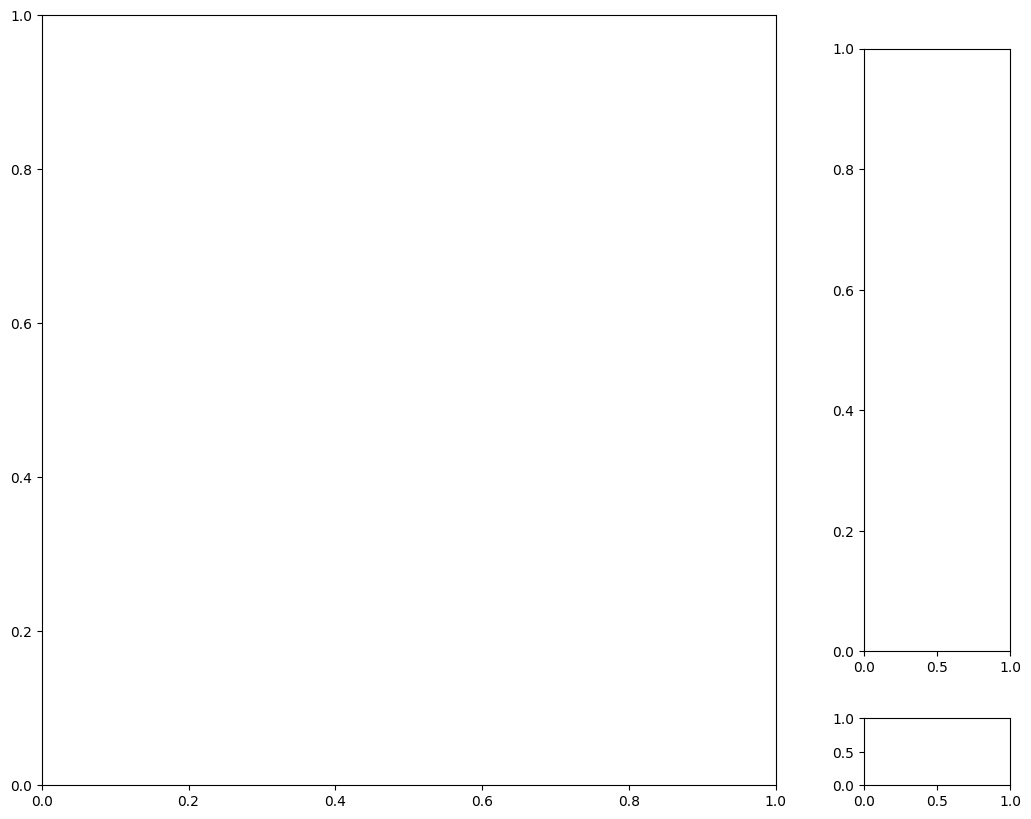

In [51]:
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Sample') #, base_size=20, label_fontsize=9, panel_size=(7, 7)
#)

In [ ]:
# we don't have source, just use sample labels here
ir.pl.clonotype_network( # color='Thaw'
    mdata,color='gex:Time') #, base_size=20, label_fontsize=9, panel_size=(7, 7)
#)

In [ ]:
# re-compute the clonotype network based on amino-acid sequence similarity and 
# define clonotype clusters.
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa", # tried 15, 25, 10, was garbage
    cutoff=10,# was 15, I would try 10 next -- definitely faster with the smaller number
)
ir.tl.define_clonotype_clusters(
    mdata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir= "primary_only" #"any"
)


In [ ]:
ir.tl.clonotype_network(mdata, min_cells=40, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Thaw", label_fontsize=9, panel_size=(7, 7), base_size=20
)
# again color by your labels, not theirs

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=33, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Sample", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=33, sequence="aa", metric="alignment")
ir.pl.clonotype_network(
    mdata, color="gex:Time", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [ ]:
mdata["airr"].obsm['airr']

In [ ]:
mdata["airr"].obsm['chain_indices']

In [ ]:
# task 1 
# this is a little more complicated due to the nature of the data itself (these are not even scalars!)

# wants sample by TCR airr heatmap as one graph, 
# with hierarchical clustering on the opposing axises and colored by differential expression
sc.tl.rank_genes_groups(mdata["gex"], groupby='Thaw', method='wilcoxon')#, key_added = "wilcoxon")
#sc.pl.rank_genes_groups(mdata["gex"], n_genes=10, groupby='cluster')
#sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="thaw", groupby="louvain_0.6") 
# you can use this to give you mean expression in groups
sc.pl.rank_genes_groups_heatmap(mdata["gex"], 
                                n_genes=10, groupby='Thaw', show_gene_labels=True,) # save="heatmap.png")

In [ ]:
# create some mask on gex data to only have tcr receptor expression

mdata["gex"].var.gene_ids


In [ ]:
mdata["gex"].obs.Thaw 

In [ ]:
len(mdata["gex"].obs[mdata["gex"].obs.Thaw == "Z-A3-1st"].index)

In [ ]:
mdata["prot"].var.gene_ids

In [ ]:
"ADT_C0090" in list(mdata["prot"].var.gene_ids)
#just do the second paper's qc and redo all the protein + gex stuff
# MouseIgG1, MouseIgG2a, MouseIgG2b, RatIgG2b, RatIgG1, RatIgG2a, and HamsterIgG
# C0090, C0091, C0092, C0095
# match these to ADT tags based on the file Xiao gave you

In [ ]:
sc.tl.umap(mdata["prot"])
sc.pl.umap(mdata["prot"], color='Thaw',) # save="UMAP.png")

In [ ]:
mdata["gex"]

In [ ]:
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='Thaw',)

In [ ]:
mdata["gex"]

In [ ]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
ir.tl.clonal_expansion(mdata)
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)
# need to have the rna data umap computed
# again change the groupby to use your sample labels
ir.pl.clonal_expansion( # groupby="gex:cluster"
    mdata, target_col="clone_id" , clip_at=20, normalize=False, groupby="gex:Thaw"
)
ir.pl.clonal_expansion(mdata, target_col="clone_id",clip_at=20, groupby="gex:Thaw")

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


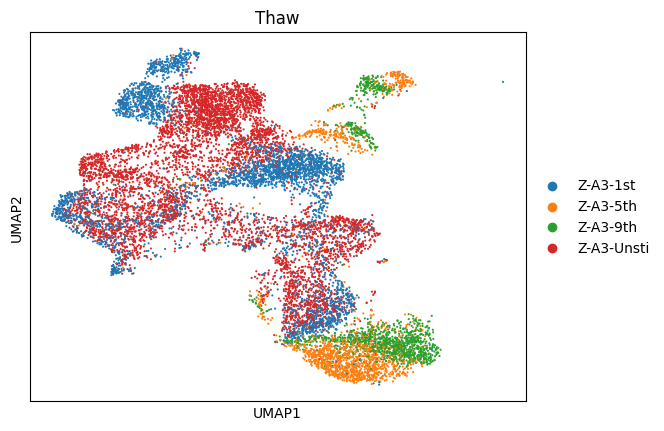

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


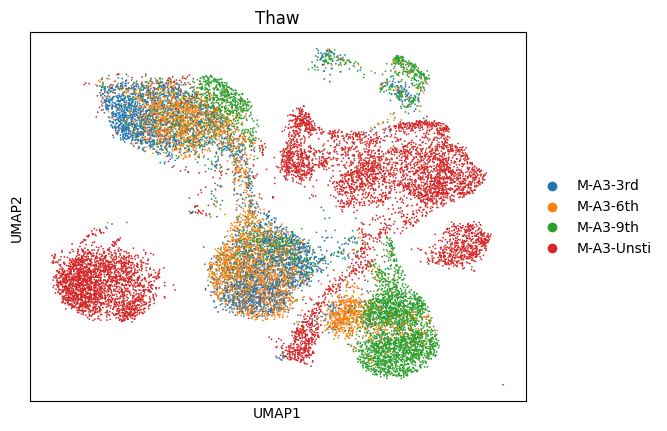

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['umap'] = {'params': {'a': a, 'b': b}}
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


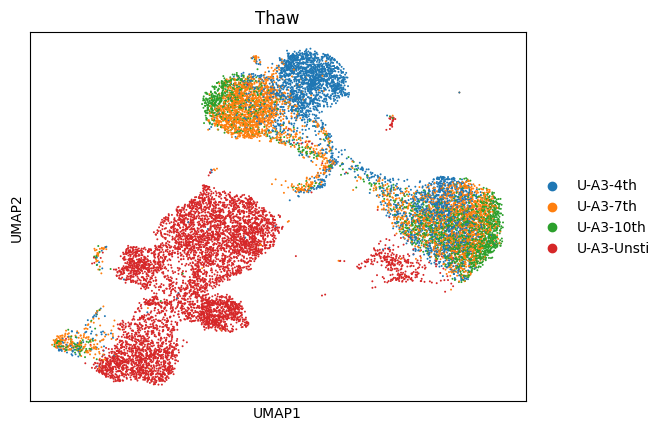

In [56]:
# task 2
# we must be missing a thaw label

# UMAP from protein data, where the clusters are colored by sample name
# create a new column called Sample that applies the predefined sample map
thaw_to_donor = {
    'Z-A3-Unsti' : "Z",
    'Z-A3-1st' : "Z", 
    'Z-A3-5th' : "Z",  
    'Z-A3-9th' : "Z",    
    "M-A3-Unsti" : "M",  
    "M-A3-3rd" : "M",
    "M-A3-6th": "M",
    "M-A3-9th" : "M",
    "U-A3-Unsti" : "U",
    "U-A3-4th" : "U",
    "U-A3-7th": "U",
    "U-A3-10th": "U"
}
# U-A3-Unsti is not getting picked up here

# [print(i)for i in mdata["prot"].obs['Thaw'].unique()]
# raise Error
mdata["prot"].obs["Sample"] = mdata["prot"].obs['Thaw'].map(thaw_to_donor)
mdata["gex"].obs["Sample"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)

Z, M, U = mdata["gex"][mdata["gex"].obs.Sample == "Z"], mdata["gex"][mdata["gex"].obs.Sample == "M"], mdata["gex"][mdata["gex"].obs.Sample == "U"]
sc.tl.umap(Z)
sc.pl.umap(Z, color='Thaw',) # save="UMAP.png")
sc.tl.umap(M)
sc.pl.umap(M, color='Thaw',) # save="UMAP.png")
sc.tl.umap(U)
sc.pl.umap(U, color='Thaw',) # save="UMAP.png")

In [ ]:
# keep all GEX, but restrict label set to each donor
thaw_to_donor = {
    'Z-A3-Unsti' : "Z-A3-Unsti",
    'Z-A3-1st' : "Z-A3-1st", 
    'Z-A3-5th' : "Z-A3-5th",  
    'Z-A3-9th' : "Z-A3-9th",    
    "M-A3-Unsti" : "NA",  
    "M-A3-3rd" : "NA",
    "M-A3-6th": "NA",
    "M-A3-9th" : "NA",
    "U-A3-Unsti" : "NA",
    "U-A3-4th" : "NA",
    "U-A3-7th": "NA",
    "U-A3-10th": "NA"
}

mdata["gex"].obs["Z_only"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='Z_only', alpha=0.5, palette={'Z-A3-Unsti':'tab:cyan',
                                                      'Z-A3-1st':'tab:olive',
                                                      'Z-A3-5th':'tab:red',
                                                      "Z-A3-9th":"tab:purple",      
                                                      'NA':'whitesmoke'})

In [ ]:
thaw_to_donor = {
    'Z-A3-Unsti' : "NA",
    'Z-A3-1st' : "NA", 
    'Z-A3-5th' : "NA",  
    'Z-A3-9th' : "NA",    
    "M-A3-Unsti" : "M-A3-Unsti",  
    "M-A3-3rd" : "M-A3-3rd",
    "M-A3-6th": "M-A3-6th",
    "M-A3-9th" : "M-A3-9th",
    "U-A3-Unsti" : "NA",
    "U-A3-4th" : "NA",
    "U-A3-7th": "NA",
    "U-A3-10th": "NA"
}
mdata["gex"].obs["M_only"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='M_only', alpha=0.5, palette={'M-A3-Unsti':'tab:cyan',
                                                      'M-A3-3rd':'tab:olive',
                                                      "M-A3-6th":'tab:red',   
                                                      'M-A3-9th':'tab:purple',
                                                      'NA':'whitesmoke'})

In [ ]:
thaw_to_donor = {
    'Z-A3-Unsti' : "NA",
    'Z-A3-1st' : "NA", 
    'Z-A3-5th' : "NA",  
    'Z-A3-9th' : "NA",    
    "M-A3-Unsti" : "NA",  
    "M-A3-3rd" : "NA",
    "M-A3-6th": "NA",
    "M-A3-9th" : "NA",
    "U-A3-Unsti" : "U-A3-Unsti",
    "U-A3-4th" : "U-A3-4th",
    "U-A3-7th": "U-A3-7th",
    "U-A3-10th": "U-A3-10th"
}
mdata["gex"].obs["U_only"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='U_only', alpha=0.5, palette={'U-A3-Unsti':'tab:cyan',
                                                      'U-A3-4th':'tab:olive',
                                                      'U-A3-7th':'tab:red',
                                                      'U-A3-10th':'tab:purple',
                                                      'NA':'whitesmoke'})

In [ ]:
# keep all GEX, but restrict label set to each unstim
thaw_to_donor = {
    'Z-A3-Unsti' : "Z-A3-Unsti",
    'Z-A3-1st' : "NA", 
    'Z-A3-5th' : "NA",  
    'Z-A3-9th' : "NA",    
    "M-A3-Unsti" : "M-A3-Unsti",  
    "M-A3-3rd" : "NA",
    "M-A3-6th": "NA",
    "M-A3-9th" : "NA",
    "U-A3-Unsti" : "U-A3-Unsti",
    "U-A3-4th" : "NA",
    "U-A3-7th": "NA",
    "U-A3-10th": "NA"
}

mdata["gex"].obs["unstim_only"] = mdata["gex"].obs['Thaw'].map(thaw_to_donor)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='unstim_only', alpha=0.5, palette={'M-A3-Unsti':'tab:cyan',
                                                      'Z-A3-Unsti':'tab:olive',
                                                      'U-A3-Unsti':'tab:red',
                                                      'NA':'whitesmoke'})

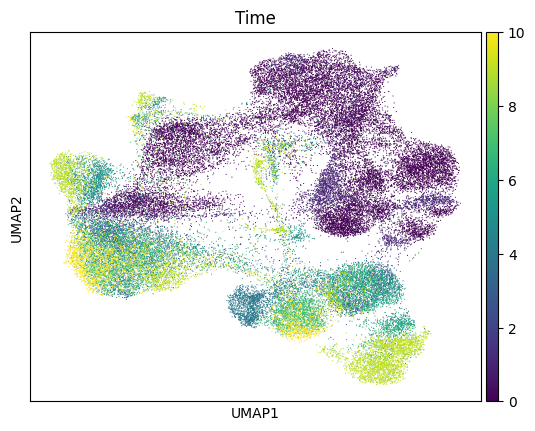

In [55]:
# task 3
# 3 UMAPs (one for each donor), non-TCR-repertoire RNA, color by different time points
# create a new column called Sample that applies the predefined sample map
thaw_to_time = {
    
    'Z-A3-Unsti' : 0,
    'Z-A3-1st' : 1, 
    'Z-A3-5th' : 5,  
    'Z-A3-9th' : 9,    
    "M-A3-Unsti" : 0,  
    "M-A3-3rd" : 3,
    "M-A3-6th": 6,
    "M-A3-9th" : 9,
    "U-A3-Unsti" : 0,
    "U-A3-4th" : 4,
    "U-A3-7th": 7,
    "U-A3-10th": 10
}
mdata["gex"].obs["Time"] = mdata["gex"].obs['Thaw'].map(thaw_to_time)
sc.tl.umap(mdata["gex"])
sc.pl.umap(mdata["gex"], color='Time' )#, save="UMAP.png")

In [ ]:
mdata.update()
mdata["gex"]

In [ ]:
mdata["airr"].obs.batch.index.intersection(mdata["airr"].obs.Thaw.index)

In [ ]:
# remove all barcodes 
#mdata["airr"].obs["Thaw"] =  #.obs.Thaw

# Create a DataFrame from the first column
first_df = pd.DataFrame(mdata["gex"].obs["Thaw"], dtype=object) #mdata["gex"].obs["Thaw"]

# Create a DataFrame from the second column
second_df = pd.DataFrame(mdata["airr"].obs.clonal_expansion ) # mdata["airr"].obs.clonal_expansion

# Perform a left join to align the indices and fill missing values with 'N/A'
aligned_df = first_df.join(second_df, how='right').fillna('N/A')
print(aligned_df)

# Update the 'second_column' in the AnnData object
mdata["airr"].obs["Thaw"] = aligned_df['Thaw']

# 
#mdata["airr"].obs.Thaw, mdata["airr"].obs.clonal_expansion
# Perform a left join to align the indices and fill missing values with 'N/A'
# mdata["airr"].obs["Thaw"] = mdata["gex"].obs["Thaw"].join(mdata["airr"].obs.clonal_expansion,
#                                                           how='left', rsuffix='_second').fillna('N/A')

# Update the 'second_column' in the AnnData object
#adata.obs['second_column'] = aligned_df['second_column_second']
mdata["airr"].obs["Thaw"]

In [ ]:
mdata["airr"].obs["Thaw"]

In [ ]:
mdata["airr"][mdata["airr"].obs["Thaw"] == thaw_name]

In [ ]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
for thaw_name in mdata["gex"].obs.Thaw.unique():
    # so now we want to apply the thaw labels to the airr and subset on that
    
    mdata_subset = mu.MuData({"gex": mdata["gex"][mdata["gex"].obs.Thaw == thaw_name],  
                   "airr": mdata["airr"][mdata["airr"].obs["Thaw"] == thaw_name],
                   "prot": mdata["prot"][mdata["prot"].obs.Thaw == thaw_name]})
    
    
    #print(mdata_subset["airr"])
    # using default parameters, `ir_dist` will compute nucleotide sequence identity
    # compute the  clonotypes on the subset but plot the rest                         
    ir.pp.ir_dist(mdata_subset)
    ir.tl.define_clonotypes(mdata_subset, receptor_arms="all", dual_ir="primary_only")
    #ir.tl.clonotype_network(mdata_subset, min_cells=30)
    ir.tl.clonal_expansion(mdata_subset)
    #print(mdata_subset["airr"].obs)#["clonal_expansion"])
    ce_name = thaw_name +"_clonal_expansion"
    ci_name = thaw_name + "_clone_id_size"
    mdata["airr"].obs[ce_name] = mdata_subset["airr"].obs["clonal_expansion"]
    mdata["airr"].obs[ci_name] = mdata_subset["airr"].obs["clone_id_size"]
#     temp_mdata = mu.MuData({"gex": file_list[0],  
#                    "airr": file_list[1],
#                    "prot": file_list[2]})
    mdata.update() # this shouldn't do anything
    print(thaw_name)
    mu.pl.embedding(
        mdata, basis="gex:umap", color=["airr:"+ce_name, "airr:"+ci_name]
    )
    # need to have the rna data umap computed
    # again change the groupby to use your sample labels
    #ir.pl.clonal_expansion( # groupby="gex:cluster"
    #    mdata_subset, target_col="clone_id" , clip_at=10, normalize=False, groupby="gex:Sample"
    #)
    #ir.pl.clonal_expansion(mdata_subset, target_col="clone_id", clip_at=10, groupby="gex:Sample")

In [ ]:
# clonal expansion -- do all this for each sample (do one for all samples, then do by donor)
ir.tl.clonal_expansion(mdata)
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)
# need to have the rna data umap computed
# again change the groupby to use your sample labels
ir.pl.clonal_expansion( # groupby="gex:cluster"
    mdata, target_col="clone_id" , clip_at=10, normalize=False, groupby="gex:Time"
)
ir.pl.clonal_expansion(mdata, target_col="clone_id", clip_at=10, groupby="gex:Time")

In [ ]:
# now let's examine the tcr data more
mdata["airr"].obs.receptor_type

In [ ]:
mdata["airr"].obs.receptor_subtype

In [ ]:
mdata["airr"].obs.chain_pairing